In [1]:
import zmq
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
PORT = "7878"
DOMAIN = "*"
SOCKET_ADDR = f"tcp://{DOMAIN}:{PORT}"

In [3]:
HELLO = "Hello"
ACK = "Acknowledge"
DENIED = "Denied"

In [4]:
context = zmq.Context()
socket = context.socket(zmq.PAIR)
socket.copy_threshold = 0
b = socket.bind(SOCKET_ADDR)
b

<SocketContext(bind='tcp://*:7878')>

In [5]:
# handshake
hello = socket.recv_string()
if hello == HELLO:
    print('Received connection:', hello)
    socket.send_string(ACK)
else:
    print("Received unkown message", hello)

Received connection: Hello


In [6]:
header = socket.recv_json()
header

{'shape': [199, 199], 'fortran_order': False, 'descr': '<f4'}

In [7]:
# acknowledge receipt of header, ask for image data
socket.send_string(ACK)

In [8]:
im_bytes = socket.recv(copy=False)
im_bytes

In [9]:
buf = memoryview(im_bytes)
im = np.frombuffer(buf, dtype=header['descr'])
im = (im * 255).astype(np.uint8)
im.shape = header['shape']
im

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00784314],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00784314,
        0.00784314],
       ...,
       [0.        , 0.00392157, 0.00392157, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.00392157, 0.00392157, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314, 0.01176471,
        0.01176471]], dtype=float32)

In [10]:
# acknowledge receipt of image data
socket.send_string(ACK)

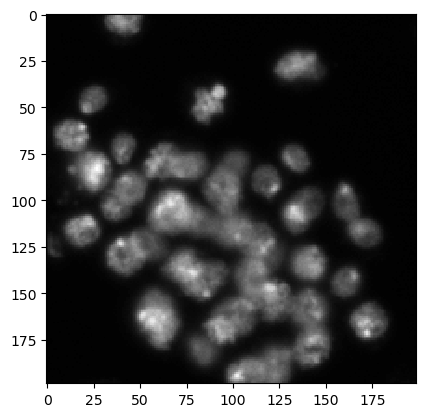

In [11]:
plt.imshow(im, cmap='gray')

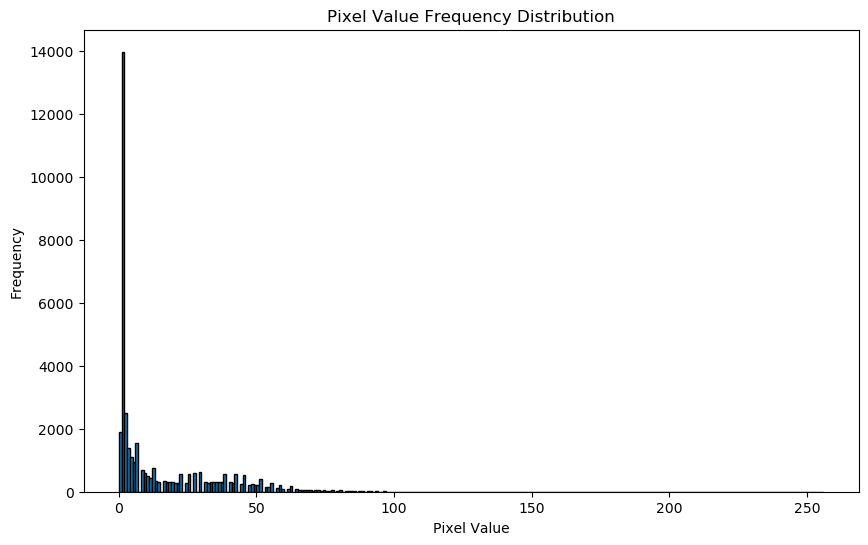

In [22]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(im.flatten(), bins=256, range=(0, 256), edgecolor='black')

# Labeling the axes and adding a title
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Frequency Distribution')

# Display the plot
plt.show()

In [23]:
print(plt.colormaps())

['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',

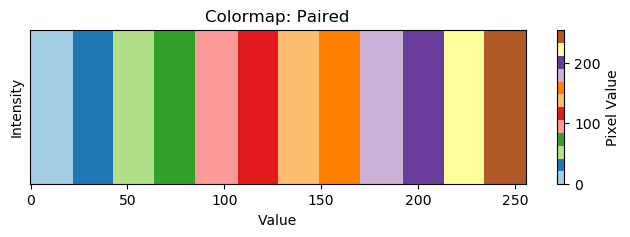

In [24]:
cmap_name = 'Paired'
# Reshape to a 2D array (gradient image) with shape (1, 256)
gradient = np.arange(256)[np.newaxis, :]

# Display the gradient image using the specified colormap
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect='auto', cmap=cmap_name)
plt.colorbar(label='Pixel Value')
plt.title(f'Colormap: {cmap_name}')
plt.xlabel('Value')
plt.ylabel('Intensity')
plt.yticks([])
plt.show()

In [25]:
ets = lambda v: int(v/65535*255)
ste = lambda v: int(v/255*65535)

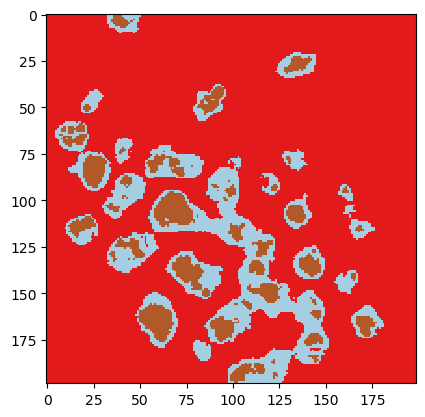

In [26]:
markers = np.zeros_like(im, dtype=np.uint8)
IDK = 0
BG = 1
FG = 2
# markers[im < ste(30)] = BG # blue
# markers[im > ste(50)] = FG # brown
markers[im < 30] = BG # blue
markers[im > 50] = FG # brown
# IDK = RED

# plt.imshow(np.array(markers / markers.max() * (2**8-1), dtype=np.uint8), cmap='gray')
plt.imshow(np.array(markers / markers.max() * (2**8-1), dtype=np.uint8), cmap=cmap_name)

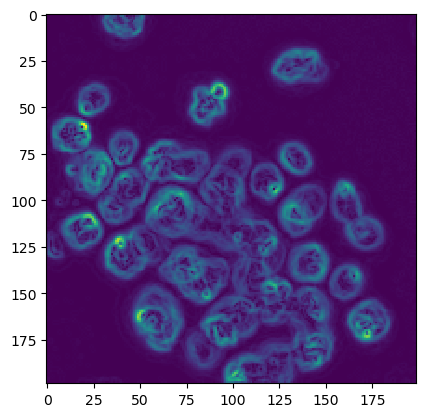

In [27]:
elevation_map = ski.filters.sobel(im)

plt.imshow(elevation_map)

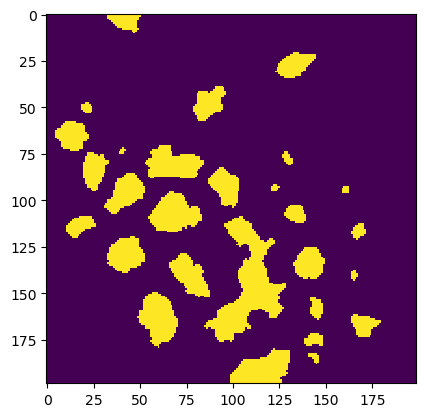

In [28]:
segmentation = ski.segmentation.watershed(elevation_map, markers)
segmentation = sp.ndimage.binary_fill_holes(segmentation - 1)

plt.imshow(segmentation)

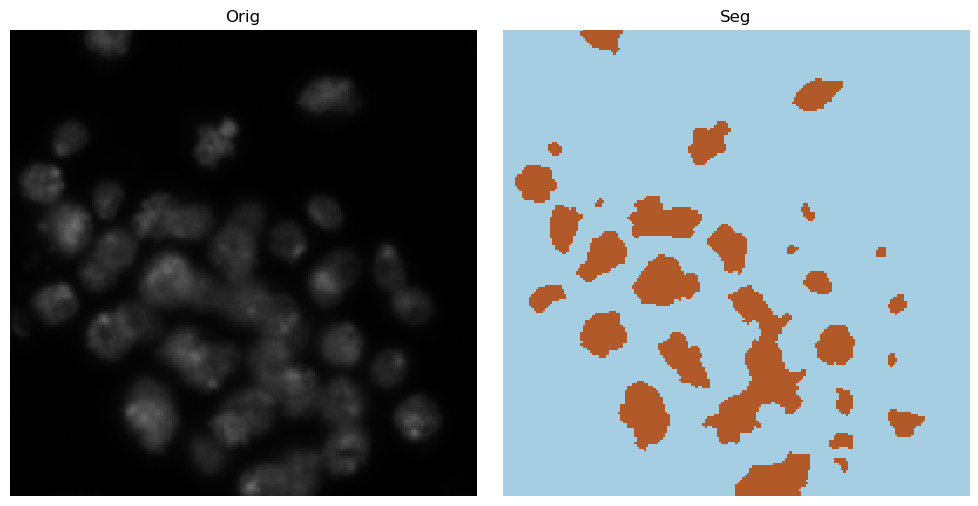

In [29]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image in the first subplot
axes[0].imshow(im, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Orig')
axes[0].axis('off')  # Hide the axes

# Display the second image in the second subplot
axes[1].imshow(segmentation, cmap=cmap_name, vmin=0, vmax=segmentation.max())
axes[1].set_title('Seg')
axes[1].axis('off')  # Hide the axes

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [30]:
labels, _ = sp.ndimage.label(segmentation)

# remove small objects
sizes = np.bincount(labels.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
segmentation = mask_sizes[labels]

labels, _ = sp.ndimage.label(segmentation)

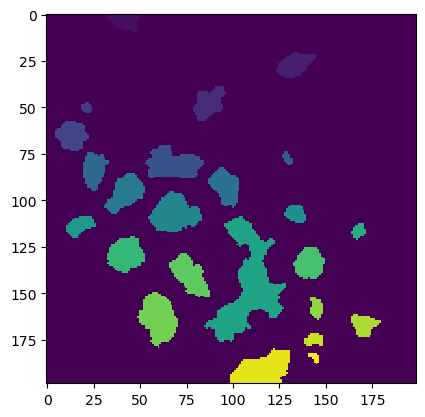

In [31]:
plt.imshow(labels)

In [32]:
return_header = np.lib.format.header_data_from_array_1_0(labels)
return_header

{'shape': (199, 199), 'fortran_order': False, 'descr': '<i4'}

In [33]:
socket.send_json(return_header)

In [34]:
ack = socket.recv_string()
if ack == ACK:
    print('Received return header ack:', ack)
else:
    print("Received unkown message", ack)

Received return header ack: Acknowledge


In [35]:
socket.send(labels, copy=False)

In [ ]:
# socket.send_string("Cancel")